In [1]:
import pandas as pd
from sklearn.mixture import GaussianMixture

df = pd.read_csv("dataset.csv", index_col=0)
df.rename(columns={'Real': 'Prediction', '40':'SpoofType', '41':'Illumination', '42':'Environment', '43':'Spoof'}, inplace=True)
# the prediction by silent face takes values 0-2. Gotta convert it.
df['Prediction'] = df['Prediction'].replace({0.0: 1, 1.0: 0, 2.0: 1})
df['Prediction'] = df['Prediction'].astype(int)

embeddings = pd.read_csv('dropout_embeddings.csv', index_col=0)

df = df.drop_duplicates()
common_index = df.index.intersection(embeddings.index)
df = df.loc[common_index]
embeddings = embeddings.loc[common_index]

pd.testing.assert_series_equal(df.index.to_series(), embeddings.index.to_series())


gmm = GaussianMixture(n_components=100, random_state=42)
clusters = gmm.fit_predict(embeddings)

In [2]:
embeddings['Spoof'] = df['Spoof']
embeddings['Cluster'] = clusters
embeddings['Illumination'] = df['Illumination']

In [17]:
import numpy as np

n = len(embeddings)
np.random.seed(seed = 42)
random_cluster = np.random.randint(5, size = n)

embeddings['Random'] = random_cluster


In [18]:
embeddings

,1,2,3,4,5,6,7,8,9,10,...,123,124,125,126,127,128,Spoof,Cluster,Illumination,Random
Data/test/6964/spoof/494405.png,0.420929,0.391198,0.395073,-0.421826,0.368112,0.353278,0.749079,0.455125,-0.878119,-0.339846,...,-0.765734,-0.755238,0.726697,-0.765685,-0.470916,0.775886,1,6,2,3
Data/test/6407/spoof/494411.png,-0.147611,0.357509,-0.029671,-0.238791,0.286075,-0.134124,0.624391,0.178886,-0.596819,-0.246836,...,-0.574118,-0.704340,0.688574,-0.656510,0.135470,0.686906,1,23,1,4
Data/test/6153/spoof/494412.png,-0.105897,-0.249867,-0.077944,0.181672,-0.120957,-0.085050,0.615739,-0.094033,-0.588235,0.141131,...,-0.605586,-0.580930,0.522196,-0.592422,0.108543,0.643653,1,41,1,2
Data/test/6411/live/494418.png,0.441198,0.528195,0.404773,-0.509041,0.446964,0.322769,0.645940,0.537904,-0.691915,-0.460678,...,-0.600595,-0.675778,0.649979,-0.616289,-0.460027,0.677907,0,76,0,4
Data/test/6336/spoof/494419.png,0.753356,0.419226,0.744619,-0.425761,0.417521,0.629097,0.054008,0.498429,-0.053692,-0.445463,...,-0.103442,0.036649,0.001247,-0.089932,-0.705690,0.065030,1,50,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Data/test/9909/live/561566.png,-0.519080,-0.166543,-0.483397,0.018525,-0.025248,-0.455392,0.709185,-0.054364,-0.614981,0.179256,...,-0.637598,-0.820888,0.733749,-0.704391,0.470004,0.818063,0,89,0,1
Data/test/6794/spoof/561567.png,-0.518010,-0.176494,-0.482479,0.025188,-0.025568,-0.453009,0.698944,-0.063262,-0.605874,0.179502,...,-0.634073,-0.810268,0.728125,-0.697531,0.467782,0.813546,1,89,1,0
Data/test/6708/spoof/561569.png,-0.531236,-0.176063,-0.496923,0.025220,-0.030200,-0.465959,0.701359,-0.064843,-0.605759,0.184143,...,-0.627472,-0.813603,0.736568,-0.705165,0.482111,0.815603,1,89,1,2
Data/test/6551/spoof/561570.png,-0.517504,-0.174754,-0.485925,0.022997,-0.027235,-0.453871,0.709815,-0.061128,-0.617192,0.182697,...,-0.638211,-0.822434,0.742672,-0.712718,0.464891,0.819803,1,89,1,4


IndexError: index 5 is out of bounds for axis 0 with size 5

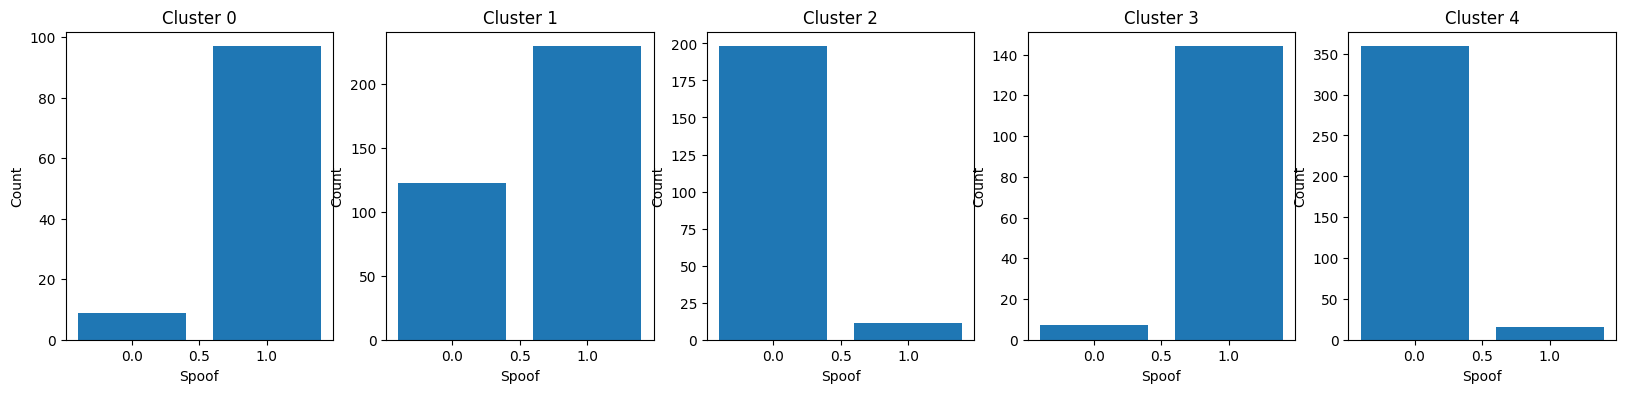

In [28]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(20, 4))

# Create a histogram for each cluster
for cluster_id, group in embeddings.groupby('Cluster'):
    # Count the frequency of each value of the current feature in the current cluster
    counts = group["Spoof"].value_counts()

    # Create a bar chart of the counts in the current subplot
    axs[cluster_id].bar(counts.index, counts.values)
    axs[cluster_id].set_xlabel("Spoof")
    axs[cluster_id].set_ylabel("Count")
    axs[cluster_id].set_title(f"Cluster {cluster_id}")

# Add a title to the overall plot
plt.suptitle("Histograms of Spoof")

# Adjust the layout of the subplots
plt.tight_layout()

# Display the overall plot
plt.show()

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

sf_column = {'Spoof':128, 'Cluster':129, 'Illumination':130, 'Random':131}

class EmbeddingsDataset(Dataset):
    def __init__(self, embeddings):
        self.embeddings = embeddings

    def __len__(self):
        return len(self.embeddings)

    def __getitem__(self, idx):
        embedding = torch.tensor(self.embeddings.iloc[idx, :128].values, dtype=torch.float32)
        spoof = torch.tensor(self.embeddings.iloc[idx, 128], dtype=torch.long)
        # 128 = Spoof, 129 = Cluster, 130 = Illumination
        domain = torch.tensor(self.embeddings.iloc[idx, 131], dtype=torch.long)
        return embedding, spoof, domain


class AdversarialModel(nn.Module):
    def __init__(self, num_clusters):
        super(AdversarialModel, self).__init__()
        self.step = nn.Sequential(
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
        )

        self.anti_spoofing_head = nn.Sequential(
            nn.Linear(64, 2)
        )

        self.domain_head = nn.Sequential(
            nn.Linear(64, num_clusters)
        )

    def forward(self, x):
        x = self.step(x)
        anti_spoofing_logits = self.anti_spoofing_head(x)
        domain_logits = self.domain_head(x)
        return anti_spoofing_logits, domain_logits

class RegularModel(nn.Module):
    def __init__(self):
        super(RegularModel, self).__init__()
        self.step = nn.Sequential(
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 2)
        )

    def forward(self, x):
        y = self.step(x)
        return y
        

In [26]:
from sklearn.model_selection import KFold
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# sf_column = {'Spoof':128, 'Cluster':129, 'Illumination':130}
class EmbeddingsDataset(Dataset):
    def __init__(self, embeddings):
        self.embeddings = embeddings

    def __len__(self):
        return len(self.embeddings)

    def __getitem__(self, idx):
        embedding = torch.tensor(self.embeddings.iloc[idx, :128].values, dtype=torch.float32)
        spoof = torch.tensor(self.embeddings.iloc[idx, 128], dtype=torch.long)
        # 128 = Spoof, 129 = Cluster, 130 = Illumination
        domain = torch.tensor(self.embeddings.iloc[idx, 129], dtype=torch.long)
        return embedding, spoof, domain

def train(target_domain, num_folds = 5, num_epochs = 4, batch_size = 64, learning_rate = 0.001):

    # Create the dataset
    dataset = EmbeddingsDataset(embeddings)

    # Create the KFold object
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

    # Iterate over the folds
    for fold, (train_indices, test_indices) in enumerate(kf.split(dataset)):
        print(f"Domain: {target_domain}, Fold {fold+1}")

        # Create the data loaders for the current fold
        train_sampler = SubsetRandomSampler(train_indices)
        test_sampler = SubsetRandomSampler(test_indices)
        train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
        test_loader = DataLoader(dataset, batch_size=batch_size, sampler=test_sampler)

        # Create the model and set the device
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model = AdversarialModel(2).to(device)

        # Define the loss functions and optimizers
        criterion = nn.CrossEntropyLoss()
        optimizer_classifier = optim.Adam(model.anti_spoofing_head.parameters(), lr=learning_rate)
        optimizer_domain = optim.Adam(model.domain_head.parameters(), lr=learning_rate)

        # Train the model for the current fold
        for epoch in range(num_epochs):
            for i, (embedding, spoof, domain) in enumerate(train_loader):
                # Move the data to the device
                embedding = embedding.to(device)
                spoof = spoof.to(device)
                domain = (domain == target_domain).long().to(device)

                # Step 1: Update all weights except the domain head
                optimizer_classifier.zero_grad()
                anti_spoofing_logits, domain_logits = model(embedding)
                loss_main = criterion(anti_spoofing_logits, spoof) - criterion(domain_logits, domain)
                loss_main.backward()
                optimizer_classifier.step()

                # Step 2: Update the domain head 
                if i%100 == 0:
                    optimizer_domain.zero_grad()
                    _, domain_logits = model(embedding)
                    loss_domain = criterion(domain_logits, domain)
                    loss_domain.backward()
                    optimizer_domain.step()

                # # Print progress
                # if (i+1) % 100 == 0:
                #     print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss_main: {loss_main.item()}, Loss_domain: {loss_domain.item()}")
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss_main: {loss_main.item()}, Loss_domain: {loss_domain.item()}")
        print("Training complete for fold", fold+1)
    
    # Set the model to evaluation mode
    model.eval()

    # Define the lists to store the true and predicted labels
    true_labels = []
    predicted_labels = []

    # Iterate over the test data
    for i, (embedding, spoof, domain) in enumerate(test_loader):

        # Move the data to the device
        embedding = embedding.to(device)
        spoof = spoof.to(device)

        # Forward pass
        anti_spoofing_logits, domain_logits = model(embedding)

        # Get the predicted labels
        _, predicted = torch.max(anti_spoofing_logits, 1)

        # Append the true and predicted labels to the lists
        true_labels += spoof.tolist()
        predicted_labels += predicted.tolist()

    # Calculate the evaluation metrics
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels)
    recall = recall_score(true_labels, predicted_labels)
    f1 = f1_score(true_labels, predicted_labels)
    roc_auc = roc_auc_score(true_labels, predicted_labels)

    metrics = [accuracy, precision, recall, f1, roc_auc]
    return metrics

In [27]:
results = {}

for i in range(5):
    metrics = train(target_domain=i)
    name = f'Random_interval5_training_{i}'
    results[name] = metrics

metrics = pd.read_csv('metrics.csv', index_col=0)

results_df = pd.DataFrame.from_dict(results, orient='index', columns = ['Accuracy', 'Precision', 'Recall', 'F1', 'ROC AUC'])

metrics = pd.concat([metrics, results_df])

metrics.to_csv('metrics.csv')

Domain: 0, Fold 1
Epoch [1/4], Loss_main: -0.18723362684249878, Loss_domain: 0.6874615550041199
Epoch [2/4], Loss_main: -0.2076023519039154, Loss_domain: 0.675388514995575
Epoch [3/4], Loss_main: -0.17381122708320618, Loss_domain: 0.659299910068512
Epoch [4/4], Loss_main: -0.22934910655021667, Loss_domain: 0.6402658820152283
Training complete for fold 1
Domain: 0, Fold 2
Epoch [1/4], Loss_main: -0.14696425199508667, Loss_domain: 0.6860234141349792
Epoch [2/4], Loss_main: -0.22533896565437317, Loss_domain: 0.67408686876297
Epoch [3/4], Loss_main: -0.30919480323791504, Loss_domain: 0.6550109386444092
Epoch [4/4], Loss_main: -0.21617957949638367, Loss_domain: 0.638133704662323
Training complete for fold 2
Domain: 0, Fold 3
Epoch [1/4], Loss_main: -0.10998457670211792, Loss_domain: 0.6758205890655518
Epoch [2/4], Loss_main: -0.20072174072265625, Loss_domain: 0.6580411791801453
Epoch [3/4], Loss_main: -0.12752848863601685, Loss_domain: 0.63765549659729
Epoch [4/4], Loss_main: -0.15169402956

In [11]:
results_df.to_csv('HundredClusters.csv')

In [7]:
def powerset(s):
    x = len(s)
    masks = [1 << i for i in range(x)]
    for i in range(1 << x):
        yield {ss for mask, ss in zip(masks, s) if i & mask}

subsets = list(powerset([i for i in range(5)]))

# remove the full and empty set
subsets = [x for x in subsets if x]
subsets.remove({0,1,2,3,4})
print(subsets)
# print(len(subsets))

[{0}, {1}, {0, 1}, {2}, {0, 2}, {1, 2}, {0, 1, 2}, {3}, {0, 3}, {1, 3}, {0, 1, 3}, {2, 3}, {0, 2, 3}, {1, 2, 3}, {0, 1, 2, 3}, {4}, {0, 4}, {1, 4}, {0, 1, 4}, {2, 4}, {0, 2, 4}, {1, 2, 4}, {0, 1, 2, 4}, {3, 4}, {0, 3, 4}, {1, 3, 4}, {0, 1, 3, 4}, {2, 3, 4}, {0, 2, 3, 4}, {1, 2, 3, 4}]


In [25]:
results = {}

for target_domain in subsets:
    # powerset_train is a train function with modified script:
                    # domain= torch.tensor([1 if x in target_domain else 0 for x in domain])
                    # domain = domain.to(device)
        
    metrics = powerset_train(target_domain=target_domain)
    name = 'Cluster(' + ', '.join([str(elem) for i,elem in enumerate(target_domain)]) + ')'
    results[name] = metrics

print(results)

Domain: {0}, Fold 1
Epoch [1/3], Loss_main: 0.342884361743927, Loss_domain: 0.16027705371379852
Epoch [2/3], Loss_main: 0.38096553087234497, Loss_domain: 0.06485865265130997
Epoch [3/3], Loss_main: 0.4013586640357971, Loss_domain: 0.03605160862207413
Training complete for fold 1
Domain: {0}, Fold 2
Epoch [1/3], Loss_main: 0.39563482999801636, Loss_domain: 0.1047213152050972
Epoch [2/3], Loss_main: 0.443238228559494, Loss_domain: 0.05563052371144295
Epoch [3/3], Loss_main: 0.5099105834960938, Loss_domain: 0.026765985414385796
Training complete for fold 2
Domain: {0}, Fold 3
Epoch [1/3], Loss_main: 0.37540706992149353, Loss_domain: 0.14230605959892273
Epoch [2/3], Loss_main: 0.45932862162590027, Loss_domain: 0.06985440105199814
Epoch [3/3], Loss_main: 0.40205439925193787, Loss_domain: 0.03859870880842209
Training complete for fold 3
Domain: {0}, Fold 4
Epoch [1/3], Loss_main: 0.39458411931991577, Loss_domain: 0.13456201553344727
Epoch [2/3], Loss_main: 0.3555627465248108, Loss_domain: 0.

In [26]:
# Create the DataFrame with index and columns
metrics = pd.read_csv('metrics.csv', index_col=0)

results_df = pd.DataFrame.from_dict(results, orient='index', columns = ['Accuracy', 'Precision', 'Recall', 'F1', 'ROC AUC'])

metrics = pd.concat([metrics, results_df])
metrics.to_csv('metrics.csv')